In [7]:
# imports
import subprocess
import numpy as np
import zipfile
import pandas as pd
import os
import gzip
import sys
import shutil
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

In [8]:
# if youre on a mac and want to run the notebook without letting youre compouter fall asleep, remember to terminate
caffein = subprocess.Popen("caffeinate", shell=True)

## 0. Load  / (remove) data

In [9]:
# config
path = os.getcwd()  # path to project directory
csvs = 'train.csv', 'test.csv', 'destinations.csv'  #  our names for the different csvs
gzs = '2013-2014.gz', '2015.gz', 'destinations.csv.gz'  # names of the gz files which we be unpacked from expedia.zip
url = "https://www.dropbox.com/s/gwrc8o99xcj6r72/Expedia.zip?dl=1" # dl=1
is_development = True
data_path = path + '/data/'
clear_hard_drive = True

In [10]:
# loads the dataset files into a passed directory otherwise current location
def load_files(url, gzs, csvs, data_path, path=os.getcwd()):
    os.chdir(path)

    if all(os.path.isfile(data_path + csv) for csv in csvs):
        print('Data already loaded')
    else:
        # if the Expedia file is not there yet init download it and write it as zip
        if not os.path.isfile('Expedia.zip'):
            print('Downloading Expedia.zip from Dropbox...')
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            
            total = 0
            with open('Expedia.zip', 'wb') as f:
                f.write(data)
                total += 1
                if total % 10000000 == 0:
                    print('Read {} lines...'.format(total))
            print('Finished downloading Expedia.zip from Dropbox')

        # Extract gz files from zip
        with zipfile.ZipFile("Expedia.zip", 'r') as zip_ref:
            print('Unzipping Expedia.zip')
            zip_ref.extractall(path)
            print('Finished unzipping Expedia.zip...')

        os.chdir(path + '/all')

        # extract the csvs from the gzs
        for csv, gz in zip(csvs, gzs):   
            with gzip.open(gz, 'rb') as f_in: 
                with open(csv, 'wb') as f_out:
                    print(f'writing {csv}...')
                    shutil.copyfileobj(f_in, f_out)
                    print(f'Finished writing {csv}')

        # clean up directory
        for f in gzs:
            os.remove(f)
            
        os.chdir(path)  # return to parent directory
        if os.path.exists(data_path): # if the data directory already exists probably empty, remove it
            shutil.rmtree(data_path)
        os.rename(path + '/all', data_path)
        os.remove('Expedia.zip')
        
        print(f'Finished.')

In [11]:
# laoding data into memory
def load_data(is_development, data_path, csvs, write_sample=False):
    print('Loading data into memory / dataframe')
    if not is_development:
        df_train = pd.read_csv(data_path + csvs[0])
        df_test = pd.read_csv(data_path + csvs[1])
        df_destination = pd.read_csv(data_path + csvs[2])  # not even needed. its enough to have the destination id as feature
    else:
        df_train = pd.read_csv(data_path + csvs[0], nrows=100000)
        df_test = pd.read_csv(data_path + csvs[1], nrows=1000)
        df_destination = pd.read_csv(data_path + csvs[2])
        
        if write_sample:
            print('Writing sample files...')
            df_train.to_csv(data_path + 'sample' + csvs[0], index=False)
            df_test.to_csv(data_path + 'sample' + csvs[1], index=False)
            print('Finished writing sample files...')
            
    print('Finished loading data into memory / dataframe')
    return df_train, df_test, df_destination

In [12]:
def remove_data(data_path, csvs, clear_hard_drive=False):
    if not clear_hard_drive:
        return
    print('Removing files from hard drive...')
    cwd = os.getcwd()
    os.chdir(data_path)
    for csv in csvs:
        try:
            print('Removing ', csv, '...')
            os.remove(csv)  
        except EnvironmentError:
            print(csv, ' not found.')
        try: 
            print('Removing sample ', csv, '...')
            os.remove('sample' + csv)
        except EnvironmentError:
            print('sample', csv, ' not found.')
    os.chdir(cwd)
    print('Finished removing files from hard drive...')

In [13]:
load_files(url, gzs, csvs, data_path, path)

Finished downloading Expedia.zip from Dropbox
Unzipping Expedia.zip
Finished unzipping Expedia.zip...
writing train.csv...
Finished writing train.csv
writing test.csv...
Finished writing test.csv
writing destinations.csv...
Finished writing destinations.csv
Finished.


In [28]:
df_train, df_test, df_destination = load_data(is_development, data_path, csvs, write_sample=True)

Loading data into memory / dataframe
Writing sample files...
Finished writing sample files...
Finished loading data into memory / dataframe


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    63078 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99929 non-null object
srch_co                      99929 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id          100000 non-null int64
srch_destination_type

In [70]:
df_train[['user_location_country', 'hotel_country']]
df_train['user_location_country'].equals(df_train['hotel_country'])

# Binary feature if booking is in same country
df_train['is_same_country'] = np.where(df_train['user_location_country'] == df_train['hotel_country'], 1, 0)
np.corrcoef(df_train['is_same_country'], df_train['hotel_cluster'])

array([[1.        , 0.00397352],
       [0.00397352, 1.        ]])

In [49]:
# .dt.dayofweek
def engineer_features(df):
    # covert data forma
    for col in df[['date_time', 'srch_ci', 'srch_co']].columns:
        df[col] = pd.to_datetime(df[col])
engineer_features(df_train)

<BarContainer object of 100 artists>

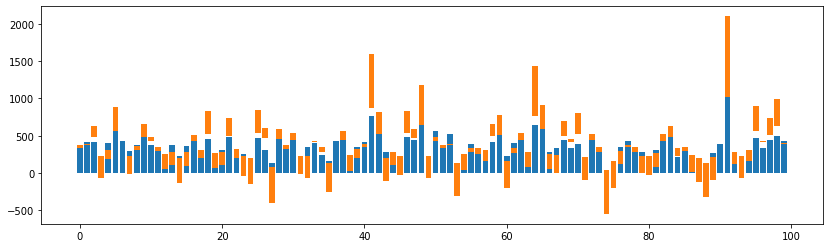

In [85]:
df_train['srch_ci_w'] = df_train['srch_ci'].dt.dayofweek
df_train['srch_co_w'] = df_train['srch_co'].dt.dayofweek

# weekday if check-in before or on Thursday and Check-out before or on Friday
df_train['is_weekend_trip'] = np.where((df_train['srch_ci_w'] < 4) & (df_train['srch_co_w'] <= 4), 0, 1)
np.corrcoef(df_train['is_weekend_trip'], df_train['hotel_cluster'])
weekend = df_train[df_train['is_weekend_trip'] == 1]['hotel_cluster'].value_counts()
weekday = df_train[df_train['is_weekend_trip'] == 0]['hotel_cluster'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(weekday.index, weekday, label = 'Weekday')
ax.bar(weekend.index, weekend, bottom = weekday, label = 'Weekend')


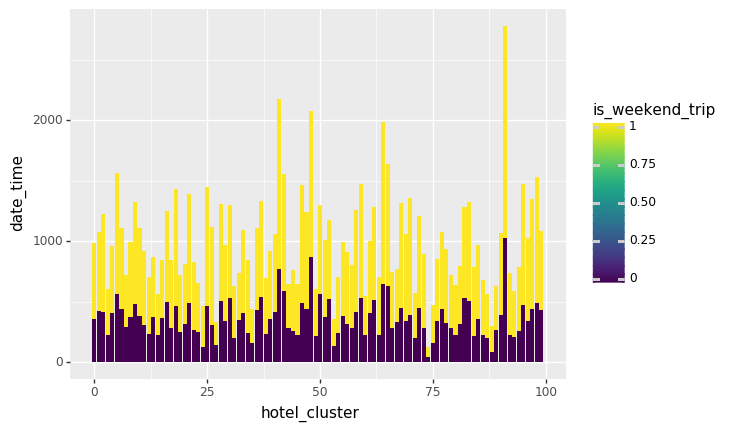

<ggplot: (7026105109)>

In [173]:
from plotnine import *

%matplotlib inline

data = df_train.groupby(['hotel_cluster', 'is_weekend_trip'])['date_time'].count().reset_index()

(ggplot(data, aes(x='hotel_cluster', y='date_time', fill='is_weekend_trip'))
 + geom_col(stat='identity'))    

# TOMEK FOR MAX

In [174]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# focus only on bookings

df = df_train[df_train['is_booking'] == 1]

### is_same_country

Text(0.5, 0, 'Hotel cluster')

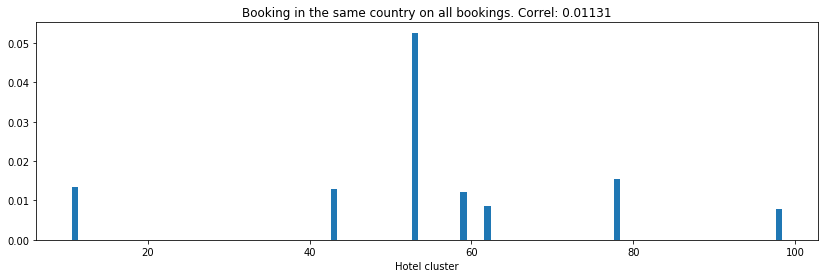

In [175]:
# Binary feature if booking is in same country
df['is_same_country'] = np.where(df['user_location_country'] == df['hotel_country'], 1, 0)
correl = np.corrcoef(df['is_same_country'], df['hotel_cluster'])

data = df.groupby(['hotel_cluster', 'is_same_country'])['date_time'].count().reset_index()

piv = data.pivot(index='hotel_cluster', columns='is_same_country', values='date_time')
piv['same_pct'] = piv[1] / (piv[0] + piv[1])

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(piv.index, piv['same_pct'])
ax.set_title(f'Booking in the same country on all bookings. Correl: {round(correl[1][0],5)}')
ax.set_xlabel('Hotel cluster')

### is_weekend_trip

The correlation is: 0.005277337196597624


Text(0.5, 0, 'Hotel cluster')

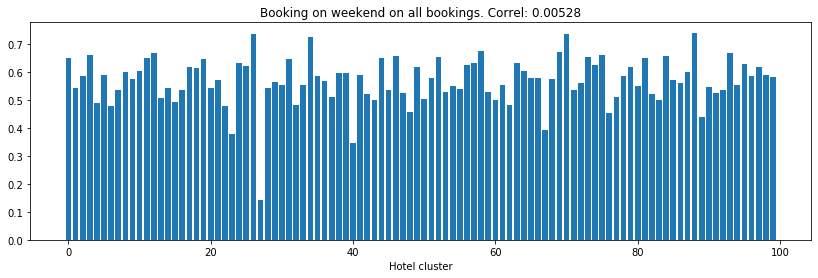

In [176]:
# convert to datetime format
def engineer_features(df):
    # covert data forma
    for col in df[['date_time', 'srch_ci', 'srch_co']].columns:
        df[col] = pd.to_datetime(df[col])
engineer_features(df)

# get day of the week
df['srch_ci_w'] = df['srch_ci'].dt.dayofweek
df['srch_co_w'] = df['srch_co'].dt.dayofweek

# weekday if check-in before or on Thursday and Check-out before or on Friday
df['is_weekend_trip'] = np.where((df['srch_ci_w'] < 4) & (df['srch_co_w'] <= 4), 0, 1)
correl = np.corrcoef(df['is_weekend_trip'], df['hotel_cluster'])
print(f'The correlation is: {correl[1][0]}')

# booking the hotel on weekend over all bookings
data = df.groupby(['hotel_cluster', 'is_weekend_trip'])['date_time'].count().reset_index()

piv = data.pivot(index='hotel_cluster', columns='is_weekend_trip', values='date_time')
piv['Weekend_pct'] = piv[1] / (piv[0] + piv[1])

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(piv.index, piv['Weekend_pct'])
ax.set_title(f'Booking on weekend on all bookings. Correl: {round(correl[1][0],5)}')
ax.set_xlabel('Hotel cluster')

### plan_time

The correlation per day: 0.03636890898821883
The correlation with grouping: 0.054318170548232854


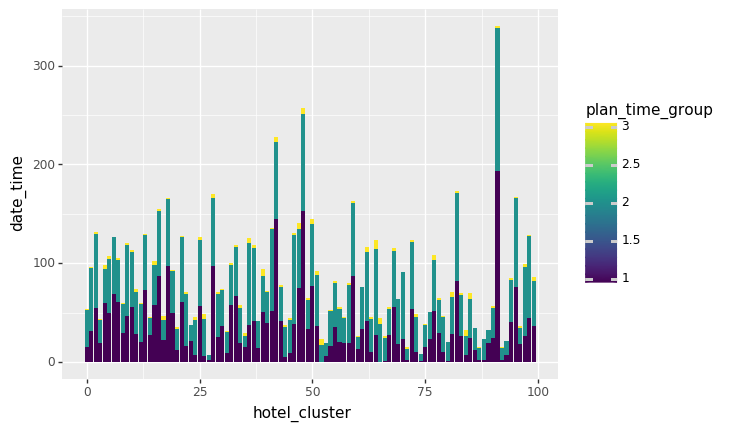

<ggplot: (7026673269)>

In [171]:
df['plan_time'] = (df['srch_co'] - df['srch_ci']).dt.days
correl = np.corrcoef(df['plan_time'], df['hotel_cluster'])
print(f'The correlation per day: {correl[1][0]}')

df['plan_time_group'] = np.where(df['plan_time'] == 1, 1, 
                                 np.where(df['plan_time'] > 7, 3, 2)) 

correl = np.corrcoef(df['plan_time_group'], df['hotel_cluster'])
print(f'The correlation with grouping: {correl[1][0]}')

data = df.groupby(['hotel_cluster', 'plan_time_group'])['date_time'].count().reset_index()

(ggplot(data, aes(x='hotel_cluster', y='date_time', fill='plan_time_group'))
 + geom_col(stat='identity')) 

In [172]:
df['is_family_trip'] = np.where(df['srch_children_cnt'] > 0, 1, 0) 
correl = np.corrcoef(df['plan_time'], df['is_family_trip'])
print(f'The correlation per day: {correl[1][0]}')

The correlation per day: 0.014296696939577304


## 1. What is the challenge?
Expedia is interested in predicting which hotel group a user is going to book.
* Does that mean in test set every row we look at eventually is a booking and the feature is the hotel class (multi class problem)
* Hence, easiest approach, drop all rows on other 'clicking events' and simply consider rows where is_booking
* But beforehadn construct feature over all rows
* Could you alternatively do, is the even going to be a booking? 1 / 0

## 2. Clean the data / engineer features

In [20]:
# find nans
def checkna(df):
    for col in df.columns:
        if df[col].isnull().any():
            print(col, '| Nan:', (df[col].isnull()).sum())

In [21]:
def fillna(df):
    """Fill empty data"""
    df['orig_destination_distance'].fillna(df['orig_destination_distance'].median(), inplace=True)

In [22]:
def counted(func):
    """A decorater to keep track of a function call count"""
    def wrapped(*args, **kwargs):
        wrapped.calls += 1
        if wrapped.calls % 10000 == 0:
            print(f'{func.__name__}: {wrapped.calls} rows...')
        return func(*args, **kwargs)
    wrapped.calls = 0
    return wrapped

In [23]:
def engineer_features(df):
    # covert data forma
    for col in df[['date_time', 'srch_ci', 'srch_co']].columns:
        df[col] = pd.to_datetime(df[col])
        
    # length of trip
    df['trip_length'] = (df['srch_co'] - df['srch_co']).astype('timedelta64[D]')
    
    # solo trip
    df['solo_trip'] = np.where(((df['srch_adults_cnt'] == 1) & (df['srch_children_cnt'] == 0)), 1, 0)
    
    # aggregate a mean booking rate
    @counted
    def aggregated_booking_rate(instance):
        if instance['is_booking'] == 0:
            return np.nan
        instance_date = instance['date_time']
        instance_id = instance['user_id']
        mean_booking_rate = df[(df['date_time'] <= instance_date) & (df['user_id'] == instance_id)]['is_booking'].mean()
        return mean_booking_rate
        
    df['booking_rate'] = df.apply(aggregated_booking_rate, axis=1)
    
    # aggregate previous bookings & clicks by hotel cluster
    @counted
    def aggregated_previous_cluster(instance, hotel_cluster):
        if instance['is_booking'] == 0:
            return np.nan, np.nan
        instance_date = instance['date_time']
        instance_id = instance['user_id']
        count_booked = len(df[(df['date_time'] <= instance_date) & (df['user_id'] == instance_id) & (df['hotel_cluster'] == hotel_cluster) & (df['is_booking'] == 1)])
        count_not_booked = len(df[(df['date_time'] <= instance_date) & (df['user_id'] == instance_id) & (df['hotel_cluster'] == hotel_cluster) & (df['is_booking'] == 0)])
        return count_booked, count_not_booked
            
    for hotel_cluster in df['hotel_cluster'].unique():
         df['booked_cluster' + str(hotel_cluster)], df['not_booked_cluster' + str(hotel_cluster)]  = zip(*df.apply(lambda instance: aggregated_previous_cluster(instance, hotel_cluster), axis=1))
    
    
    # current strategy is to only use rows where booking is one and aggregate all info
    len_before = len(df)
    df = df[df['is_booking'] == 1]
    df = df.drop('is_booking', axis=1)
    print(f'Dropped {len_before - len(df)} rows which did not represent a booking.')
    return df

def parallel_feature_engineering(df, func=engineer_features, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [24]:
def finalize(df):
    """Date times need to be removed before a model is trained."""
    for col in ['date_time', 'srch_ci', 'srch_co', 'user_id']:
        try:
            df.drop(col, axis=1, inplace=True)
        except KeyError:
            pass

In [25]:
# TODO: DOES IT REPRESENT LEAKAGE TO KNOW THE DISTANCE TO THE BOOKED HOTEL BEFOREHAND? I GUESS SO?
def handle_leakage(df):
    # If its a booking can I already know the distance to the hotel?
    df.drop(['orig_destination_distance'], axis=1, inplace=True)

In [26]:
fillna(df_train)

In [27]:
df_train = parallel_feature_engineering(df_train)

aggregated_booking_rate: 10000 rows...
aggregated_booking_rate: 10000 rows...
aggregated_booking_rate: 10000 rows...
aggregated_booking_rate: 10000 rows...
aggregated_booking_rate: 20000 rows...
aggregated_booking_rate: 20000 rows...
aggregated_booking_rate: 20000 rows...
aggregated_booking_rate: 20000 rows...
aggregated_previous_cluster: 10000 rows...
aggregated_previous_cluster: 10000 rows...
aggregated_previous_cluster: 10000 rows...
aggregated_previous_cluster: 10000 rows...
aggregated_previous_cluster: 20000 rows...
aggregated_previous_cluster: 20000 rows...
aggregated_previous_cluster: 20000 rows...
aggregated_previous_cluster: 20000 rows...
aggregated_previous_cluster: 30000 rows...
aggregated_previous_cluster: 30000 rows...
aggregated_previous_cluster: 30000 rows...
aggregated_previous_cluster: 30000 rows...
aggregated_previous_cluster: 40000 rows...
aggregated_previous_cluster: 40000 rows...
aggregated_previous_cluster: 40000 rows...
aggregated_previous_cluster: 40000 rows...


aggregated_previous_cluster: 450000 rows...
aggregated_previous_cluster: 460000 rows...
aggregated_previous_cluster: 460000 rows...
aggregated_previous_cluster: 470000 rows...
aggregated_previous_cluster: 470000 rows...
aggregated_previous_cluster: 460000 rows...
aggregated_previous_cluster: 470000 rows...
aggregated_previous_cluster: 480000 rows...
aggregated_previous_cluster: 470000 rows...
aggregated_previous_cluster: 480000 rows...
aggregated_previous_cluster: 480000 rows...
aggregated_previous_cluster: 490000 rows...
aggregated_previous_cluster: 490000 rows...
aggregated_previous_cluster: 480000 rows...
aggregated_previous_cluster: 490000 rows...
aggregated_previous_cluster: 500000 rows...
aggregated_previous_cluster: 500000 rows...
aggregated_previous_cluster: 490000 rows...
aggregated_previous_cluster: 500000 rows...
aggregated_previous_cluster: 510000 rows...
aggregated_previous_cluster: 510000 rows...
aggregated_previous_cluster: 500000 rows...
aggregated_previous_cluster: 510

aggregated_previous_cluster: 910000 rows...
aggregated_previous_cluster: 930000 rows...
aggregated_previous_cluster: 930000 rows...
aggregated_previous_cluster: 940000 rows...
aggregated_previous_cluster: 920000 rows...
aggregated_previous_cluster: 940000 rows...
aggregated_previous_cluster: 940000 rows...
aggregated_previous_cluster: 950000 rows...
aggregated_previous_cluster: 930000 rows...
aggregated_previous_cluster: 950000 rows...
aggregated_previous_cluster: 950000 rows...
aggregated_previous_cluster: 960000 rows...
aggregated_previous_cluster: 940000 rows...
aggregated_previous_cluster: 960000 rows...
aggregated_previous_cluster: 960000 rows...
aggregated_previous_cluster: 970000 rows...
aggregated_previous_cluster: 950000 rows...
aggregated_previous_cluster: 970000 rows...
aggregated_previous_cluster: 970000 rows...
aggregated_previous_cluster: 980000 rows...
aggregated_previous_cluster: 960000 rows...
aggregated_previous_cluster: 980000 rows...
aggregated_previous_cluster: 980

aggregated_previous_cluster: 1360000 rows...
aggregated_previous_cluster: 1390000 rows...
aggregated_previous_cluster: 1390000 rows...
aggregated_previous_cluster: 1400000 rows...
aggregated_previous_cluster: 1370000 rows...
aggregated_previous_cluster: 1400000 rows...
aggregated_previous_cluster: 1400000 rows...
aggregated_previous_cluster: 1410000 rows...
aggregated_previous_cluster: 1380000 rows...
aggregated_previous_cluster: 1410000 rows...
aggregated_previous_cluster: 1420000 rows...
aggregated_previous_cluster: 1410000 rows...
aggregated_previous_cluster: 1390000 rows...
aggregated_previous_cluster: 1420000 rows...
aggregated_previous_cluster: 1420000 rows...
aggregated_previous_cluster: 1400000 rows...
aggregated_previous_cluster: 1430000 rows...
aggregated_previous_cluster: 1430000 rows...
aggregated_previous_cluster: 1430000 rows...
aggregated_previous_cluster: 1440000 rows...
aggregated_previous_cluster: 1410000 rows...
aggregated_previous_cluster: 1440000 rows...
aggregated

aggregated_previous_cluster: 1840000 rows...
aggregated_previous_cluster: 1850000 rows...
aggregated_previous_cluster: 1820000 rows...
aggregated_previous_cluster: 1850000 rows...
aggregated_previous_cluster: 1860000 rows...
aggregated_previous_cluster: 1860000 rows...
aggregated_previous_cluster: 1870000 rows...
aggregated_previous_cluster: 1830000 rows...
aggregated_previous_cluster: 1860000 rows...
aggregated_previous_cluster: 1870000 rows...
aggregated_previous_cluster: 1840000 rows...
aggregated_previous_cluster: 1870000 rows...
aggregated_previous_cluster: 1880000 rows...
aggregated_previous_cluster: 1880000 rows...
aggregated_previous_cluster: 1850000 rows...
aggregated_previous_cluster: 1890000 rows...
aggregated_previous_cluster: 1880000 rows...
aggregated_previous_cluster: 1890000 rows...
aggregated_previous_cluster: 1900000 rows...
aggregated_previous_cluster: 1860000 rows...
aggregated_previous_cluster: 1890000 rows...
aggregated_previous_cluster: 1900000 rows...
aggregated

aggregated_previous_cluster: 2300000 rows...
aggregated_previous_cluster: 2310000 rows...
aggregated_previous_cluster: 2270000 rows...
aggregated_previous_cluster: 2320000 rows...
aggregated_previous_cluster: 2310000 rows...
aggregated_previous_cluster: 2320000 rows...
aggregated_previous_cluster: 2280000 rows...
aggregated_previous_cluster: 2330000 rows...
aggregated_previous_cluster: 2320000 rows...
aggregated_previous_cluster: 2330000 rows...
aggregated_previous_cluster: 2290000 rows...
aggregated_previous_cluster: 2340000 rows...
aggregated_previous_cluster: 2330000 rows...
aggregated_previous_cluster: 2340000 rows...
aggregated_previous_cluster: 2300000 rows...
aggregated_previous_cluster: 2350000 rows...
aggregated_previous_cluster: 2340000 rows...
aggregated_previous_cluster: 2350000 rows...
aggregated_previous_cluster: 2310000 rows...
aggregated_previous_cluster: 2360000 rows...
aggregated_previous_cluster: 2350000 rows...
aggregated_previous_cluster: 2360000 rows...
aggregated

/Users/tomek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [22]:
pd.set_option('display.max_columns', None)
df_train.head()

,booked_cluster0,booked_cluster1,booked_cluster10,booked_cluster11,booked_cluster12,booked_cluster13,booked_cluster14,booked_cluster15,booked_cluster16,booked_cluster17,booked_cluster18,booked_cluster19,booked_cluster2,booked_cluster20,booked_cluster21,booked_cluster22,booked_cluster23,booked_cluster24,booked_cluster25,booked_cluster26,booked_cluster27,booked_cluster28,booked_cluster29,booked_cluster3,booked_cluster30,booked_cluster31,booked_cluster32,booked_cluster33,booked_cluster34,booked_cluster35,booked_cluster36,booked_cluster37,booked_cluster38,booked_cluster39,booked_cluster4,booked_cluster40,booked_cluster41,booked_cluster42,booked_cluster43,booked_cluster44,booked_cluster45,booked_cluster46,booked_cluster47,booked_cluster48,booked_cluster49,booked_cluster5,booked_cluster50,booked_cluster51,booked_cluster52,booked_cluster53,booked_cluster54,booked_cluster55,booked_cluster56,booked_cluster57,booked_cluster58,booked_cluster59,booked_cluster6,booked_cluster60,booked_cluster61,booked_cluster62,booked_cluster63,booked_cluster64,booked_cluster65,booked_cluster66,booked_cluster67,booked_cluster68,booked_cluster69,booked_cluster7,booked_cluster70,booked_cluster71,booked_cluster72,booked_cluster73,booked_cluster74,booked_cluster75,booked_cluster76,booked_cluster77,booked_cluster78,booked_cluster79,booked_cluster8,booked_cluster80,booked_cluster81,booked_cluster82,booked_cluster83,booked_cluster84,booked_cluster85,booked_cluster86,booked_cluster87,booked_cluster88,booked_cluster89,booked_cluster9,booked_cluster90,booked_cluster91,booked_cluster92,booked_cluster93,booked_cluster94,booked_cluster95,booked_cluster96,booked_cluster97,booked_cluster98,booked_cluster99,booking_rate,channel,cnt,date_time,hotel_cluster,hotel_continent,hotel_country,hotel_market,is_mobile,is_package,not_booked_cluster0,not_booked_cluster1,not_booked_cluster10,not_booked_cluster11,not_booked_cluster12,not_booked_cluster13,not_booked_cluster14,not_booked_cluster15,not_booked_cluster16,not_booked_cluster17,not_booked_cluster18,not_booked_cluster19,not_booked_cluster2,not_booked_cluster20,not_booked_cluster21,not_booked_cluster22,not_booked_cluster23,not_booked_cluster24,not_booked_cluster25,not_booked_cluster26,not_booked_cluster27,not_booked_cluster28,not_booked_cluster29,not_booked_cluster3,not_booked_cluster30,not_booked_cluster31,not_booked_cluster32,not_booked_cluster33,not_booked_cluster34,not_booked_cluster35,not_booked_cluster36,not_booked_cluster37,not_booked_cluster38,not_booked_cluster39,not_booked_cluster4,not_booked_cluster40,not_booked_cluster41,not_booked_cluster42,not_booked_cluster43,not_booked_cluster44,not_booked_cluster45,not_booked_cluster46,not_booked_cluster47,not_booked_cluster48,not_booked_cluster49,not_booked_cluster5,not_booked_cluster50,not_booked_cluster51,not_booked_cluster52,not_booked_cluster53,not_booked_cluster54,not_booked_cluster55,not_booked_cluster56,not_booked_cluster57,not_booked_cluster58,not_booked_cluster59,not_booked_cluster6,not_booked_cluster60,not_booked_cluster61,not_booked_cluster62,not_booked_cluster63,not_booked_cluster64,not_booked_cluster65,not_booked_cluster66,not_booked_cluster67,not_booked_cluster68,not_booked_cluster69,not_booked_cluster7,not_booked_cluster70,not_booked_cluster71,not_booked_cluster72,not_booked_cluster73,not_booked_cluster74,not_booked_cluster75,not_booked_cluster76,not_booked_cluster77,not_booked_cluster78,not_booked_cluster79,not_booked_cluster8,not_booked_cluster80,not_booked_cluster81,not_booked_cluster82,not_booked_cluster83,not_booked_cluster84,not_booked_cluster85,not_booked_cluster86,not_booked_cluster87,not_booked_cluster88,not_booked_cluster89,not_booked_cluster9,not_booked_cluster90,not_booked_cluster91,not_booked_cluster92,not_booked_cluster93,not_booked_cluster94,not_booked_cluster95,not_booked_cluster96,not_booked_cluster97,not_booked_cluster98,not_booked_cluster99,orig_destination_distance,posa_continent,site_name,solo_trip,srch_adults_cnt,srch_children_cnt,srch_ci,src

In [23]:
finalize(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8270 entries, 1 to 99931
Columns: 222 entries, booked_cluster0 to user_location_region
dtypes: float64(203), int64(19)
memory usage: 14.1 MB


## 3. Data exploration

In [24]:
# What are the most common hotel clusters?
df_train.hotel_cluster.value_counts().head(10)

91    340
48    257
42    228
82    173
28    170
95    167
18    166
59    163
16    155
50    145
Name: hotel_cluster, dtype: int64

<BarContainer object of 100 artists>

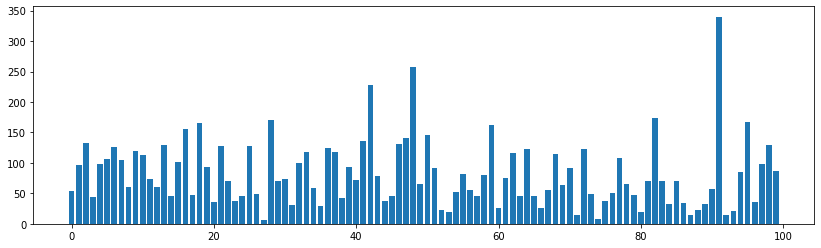

In [25]:
# plot hotel clusters
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
x = df_train['hotel_cluster'].value_counts().reset_index()
ax.bar(x['index'].to_numpy(), x['hotel_cluster'].to_numpy())

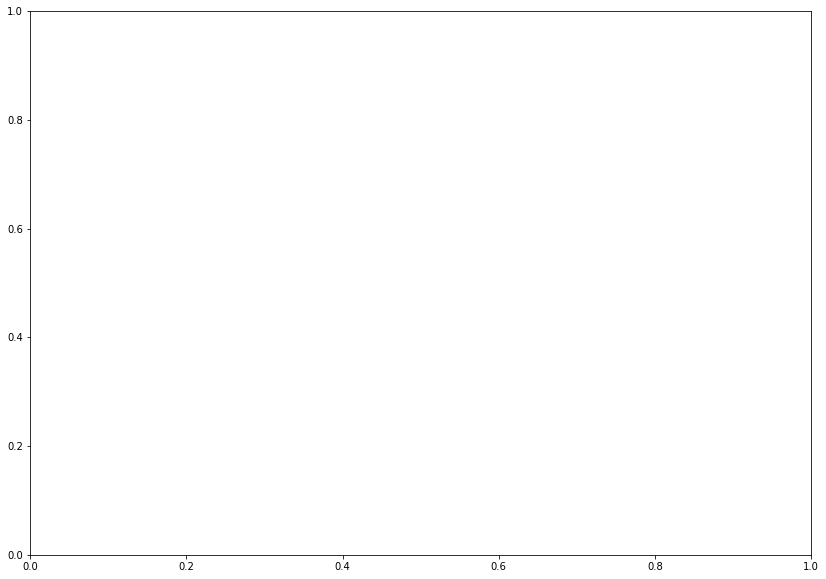

In [50]:
fig, ax = plt.subplots(figsize=(14, 10))
# sns.heatmap(df_train.corr(),ax=ax,annot=True,linewidths=2)

## 3. Models

In [27]:
# pepare dfs for training
X_train = df_train.drop(['hotel_cluster'], axis=1)
y_train = df_train['hotel_cluster']

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings

warnings.simplefilter("ignore")

forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train, y_train)

np.mean(cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy'))

0.4714631197097945

In [42]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

np.mean(cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy'))

0.41765417170495767

In [40]:
# feature importance in random forest
feature_importances = pd.DataFrame(forest.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
srch_destination_id,0.031396
booking_rate,0.030627
hotel_market,0.030577
orig_destination_distance,0.025559
user_location_city,0.018379
...,...
booked_cluster71,0.000448
not_booked_cluster74,0.000428
booked_cluster27,0.000273
booked_cluster74,0.000241


In [43]:
# feature importance in decision tree
feature_importances = pd.DataFrame(tree.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
hotel_market,0.042993
srch_destination_id,0.039948
orig_destination_distance,0.035921
booking_rate,0.029515
user_location_city,0.016698
...,...
booked_cluster92,0.000482
booked_cluster87,0.000442
posa_continent,0.000368
trip_length,0.000000


In [49]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1, max_depth=2, eta=1)

X_train_xgb = X_train.loc[:,feature_importances.index[:50]]
xgb.fit(X_train_xgb, y_train)

np.mean(cross_val_score(xgb, X_train, y_train, cv=10, scoring='accuracy'))

0.5546553808948005

## 4. Remove data / kill subproccess

In [7]:
remove_data(data_path, csvs, clear_hard_drive)

Removing files from hard drive...
Removing  train.csv ...
Removing sample  train.csv ...
Removing  test.csv ...
Removing sample  test.csv ...
Removing  destinations.csv ...
Removing sample  destinations.csv ...
sample destinations.csv  not found.
Finished removing files from hard drive...


In [5]:
caffein.kill()